In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import glob
from pathlib import Path


current_dir = Path.cwd()
raw_data_dir = current_dir.parent / 'raw_data'
viz_dir = current_dir.parent / 'viz'

import glob
import os
raw_data_path= glob.glob(f'{raw_data_dir}/*')

In [4]:
gdf_list = []

for file in raw_data_path:
    dataframe = gpd.read_file(file)
    gdf_list.append(dataframe)

gdf = pd.concat(gdf_list)
gdf.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 81517 entries, 0 to 34234
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   CCN                   81517 non-null  object             
 1   REPORT_DAT            81517 non-null  datetime64[ms, UTC]
 2   SHIFT                 81517 non-null  object             
 3   METHOD                81517 non-null  object             
 4   OFFENSE               81517 non-null  object             
 5   BLOCK                 81517 non-null  object             
 6   XBLOCK                81517 non-null  float64            
 7   YBLOCK                81517 non-null  float64            
 8   WARD                  81503 non-null  object             
 9   ANC                   81503 non-null  object             
 10  DISTRICT              80435 non-null  object             
 11  PSA                   80698 non-null  object             
 12  N

In [5]:
# Touch up column headers
gdf.columns = gdf.columns.str.lower().str.replace(' ', '_')
gdf.columns

Index(['ccn', 'report_dat', 'shift', 'method', 'offense', 'block', 'xblock',
       'yblock', 'ward', 'anc', 'district', 'psa', 'neighborhood_cluster',
       'block_group', 'census_tract', 'voting_precinct', 'latitude',
       'longitude', 'bid', 'start_date', 'end_date', 'objectid',
       'octo_record_id', 'geometry'],
      dtype='object')

In [6]:
# Clean up datetime columns
gdf['reported_date_only'] = gdf.report_dat.dt.date
gdf['reported_month'] = pd.to_datetime(gdf['reported_date_only']).dt.month
gdf['reported_year'] = pd.to_datetime(gdf['reported_date_only']).dt.year
gdf['reported_year_month']  = pd.to_datetime(gdf['reported_date_only']).dt.strftime('%Y-%m')

gdf[['reported_date_only', 'reported_month', 'reported_year', 'reported_year_month']]

,reported_date_only,reported_month,reported_year,reported_year_month
0,2024-07-30,7,2024,2024-07
1,2024-09-30,9,2024,2024-09
2,2024-01-28,1,2024,2024-01
3,2024-01-25,1,2024,2024-01
4,2024-01-26,1,2024,2024-01
...,...,...,...,...
34230,2023-06-16,6,2023,2023-06
34231,2023-11-20,11,2023,2023-11
34232,2023-01-29,1,2023,2023-01
34233,2023-05-21,5,2023,2023-05


In [7]:
gdf['reported_date_only'] = pd.to_datetime(gdf['reported_date_only'])

# Set the smallest date as the start date
start_date = gdf['reported_date_only'].min()

# Calculate the start of the 7-day interval 
gdf['reported_week'] = start_date + pd.to_timedelta(
    ((gdf['reported_date_only'] - start_date).dt.days // 7) * 7, unit='d'
)
gdf['reported_week'] = gdf['reported_week'].dt.strftime('%m-%d')

# Calculate the start of the 14-day interval for each date
gdf['reported_every_two_week'] = start_date + pd.to_timedelta(
    ((gdf['reported_date_only'] - start_date).dt.days // 14) * 14, unit='d'
)
gdf['reported_every_two_week'] = gdf['reported_every_two_week'].dt.strftime('%m-%d')

In [8]:
top_offenses = gdf.offense.value_counts(normalize=True).head(6).reset_index().offense.to_list()
top_offenses_gdf = gdf[gdf.offense.isin(top_offenses)]

top_offenses_gdf.shape[0] / gdf.shape[0]

0.9879288982666192

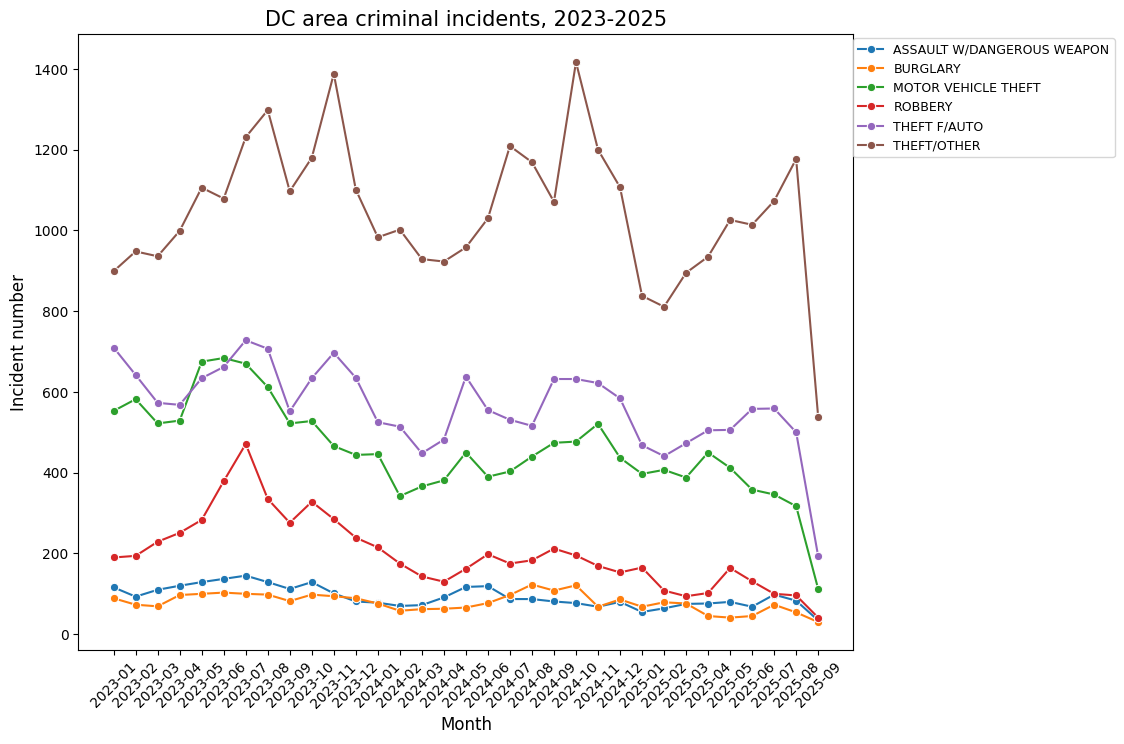

In [9]:
top_offense_by_month = top_offenses_gdf.groupby('offense').reported_year_month.value_counts().sort_index().reset_index()

fig,ax= plt.subplots(figsize=(10,8))
sns.lineplot(
    top_offense_by_month,
    x='reported_year_month',
    y='count',
    hue='offense',
    marker='o'
)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Incident number', fontsize=12)
ax.set_xticks(range(len(top_offense_by_month['reported_year_month'].unique())))
ax.set_xticklabels(top_offense_by_month['reported_year_month'].unique(), rotation=45)

plt.legend(loc=(1, 0.8), prop={'size': 9}, markerscale=1)

title_text = 'DC area criminal incidents, 2023-2025'
plt.title(title_text, fontsize=15)

plt.show()

In [10]:
s1 = gdf[['offense', 'reported_date_only', 'reported_year', 'reported_month']].copy()
# Ensure reported_date_only is datetime
s1['reported_date_only'] = pd.to_datetime(s1['reported_date_only'])

mask = (
    (s1['reported_date_only'].dt.month >= 7) &
    ((s1['reported_date_only'].dt.month < 9) |((s1['reported_date_only'].dt.month == 9) & (s1['reported_date_only'].dt.day < 16))) &
    (s1['offense'].isin(top_offense.offense.to_list()))
)
s1 = s1[mask]
s1

NameError: name 'top_offense' is not defined

In [ ]:
gdf[['offense', 'reported_date_only', 'reported_year', 'reported_month', 'method']]

,offense,reported_date_only,reported_year,reported_month,method
0,HOMICIDE,2024-07-30,2024,7,GUN
1,HOMICIDE,2024-09-30,2024,9,GUN
2,THEFT/OTHER,2024-01-28,2024,1,OTHERS
3,ROBBERY,2024-01-25,2024,1,OTHERS
4,THEFT/OTHER,2024-01-26,2024,1,OTHERS
...,...,...,...,...,...
34230,THEFT F/AUTO,2023-06-16,2023,6,OTHERS
34231,MOTOR VEHICLE THEFT,2023-11-20,2023,11,OTHERS
34232,ASSAULT W/DANGEROUS WEAPON,2023-01-29,2023,1,GUN
34233,ASSAULT W/DANGEROUS WEAPON,2023-05-21,2023,5,GUN


In [ ]:
s1 = gdf[['offense', 'reported_date_only', 'reported_year', 'reported_month', 'method']].copy()
s1['reported_date_only'] = pd.to_datetime(s1['reported_date_only'])

mask = (
    (s1['reported_date_only'].dt.month >= 7) &
    ((s1['reported_date_only'].dt.month < 9) |((s1['reported_date_only'].dt.month == 9) & (s1['reported_date_only'].dt.day < 16))) &
    (s1['offense'].isin(top_offense.offense.to_list()))
)
s1 = s1[mask]


s1['week_bin'] = ((s1['reported_date_only'] - pd.to_datetime(s1['reported_year'].astype(str) + '-07-01')).dt.days // 7)

s1['week_start'] = pd.to_datetime(s1['reported_year'].astype(str) + '-07-01') + pd.to_timedelta(s1['week_bin']*7, unit='D')
s1['week_end'] = s1['week_start'] + pd.Timedelta(days=6)
s1['week_label'] = s1['week_start'].dt.strftime('%m-%d') + " to " + s1['week_end'].dt.strftime('%m-%d')

In [ ]:
s1

,offense,reported_date_only,reported_year,reported_month,method,week_bin,week_start,week_end,week_label
93,THEFT/OTHER,2024-07-17,2024,7,OTHERS,2,2024-07-15,2024-07-21,07-15 to 07-21
94,THEFT/OTHER,2024-07-17,2024,7,OTHERS,2,2024-07-15,2024-07-21,07-15 to 07-21
95,THEFT/OTHER,2024-07-17,2024,7,OTHERS,2,2024-07-15,2024-07-21,07-15 to 07-21
96,MOTOR VEHICLE THEFT,2024-07-19,2024,7,OTHERS,2,2024-07-15,2024-07-21,07-15 to 07-21
97,ROBBERY,2024-07-19,2024,7,GUN,2,2024-07-15,2024-07-21,07-15 to 07-21
...,...,...,...,...,...,...,...,...,...
34224,MOTOR VEHICLE THEFT,2023-09-10,2023,9,OTHERS,10,2023-09-09,2023-09-15,09-09 to 09-15
34225,THEFT/OTHER,2023-09-11,2023,9,OTHERS,10,2023-09-09,2023-09-15,09-09 to 09-15
34226,THEFT/OTHER,2023-09-13,2023,9,OTHERS,10,2023-09-09,2023-09-15,09-09 to 09-15
34229,THEFT F/AUTO,2023-07-19,2023,7,OTHERS,2,2023-07-15,2023-07-21,07-15 to 07-21


In [ ]:
x_labels = sorted(s1['week_label'].unique(), key=lambda x: pd.to_datetime(x.split(' to ')[0], format='%m-%d'))
x_labels

['07-01 to 07-07',
 '07-08 to 07-14',
 '07-15 to 07-21',
 '07-22 to 07-28',
 '07-29 to 08-04',
 '08-05 to 08-11',
 '08-12 to 08-18',
 '08-19 to 08-25',
 '08-26 to 09-01',
 '09-02 to 09-08',
 '09-09 to 09-15']

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_24255/3508562429.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 1, 1, 1])


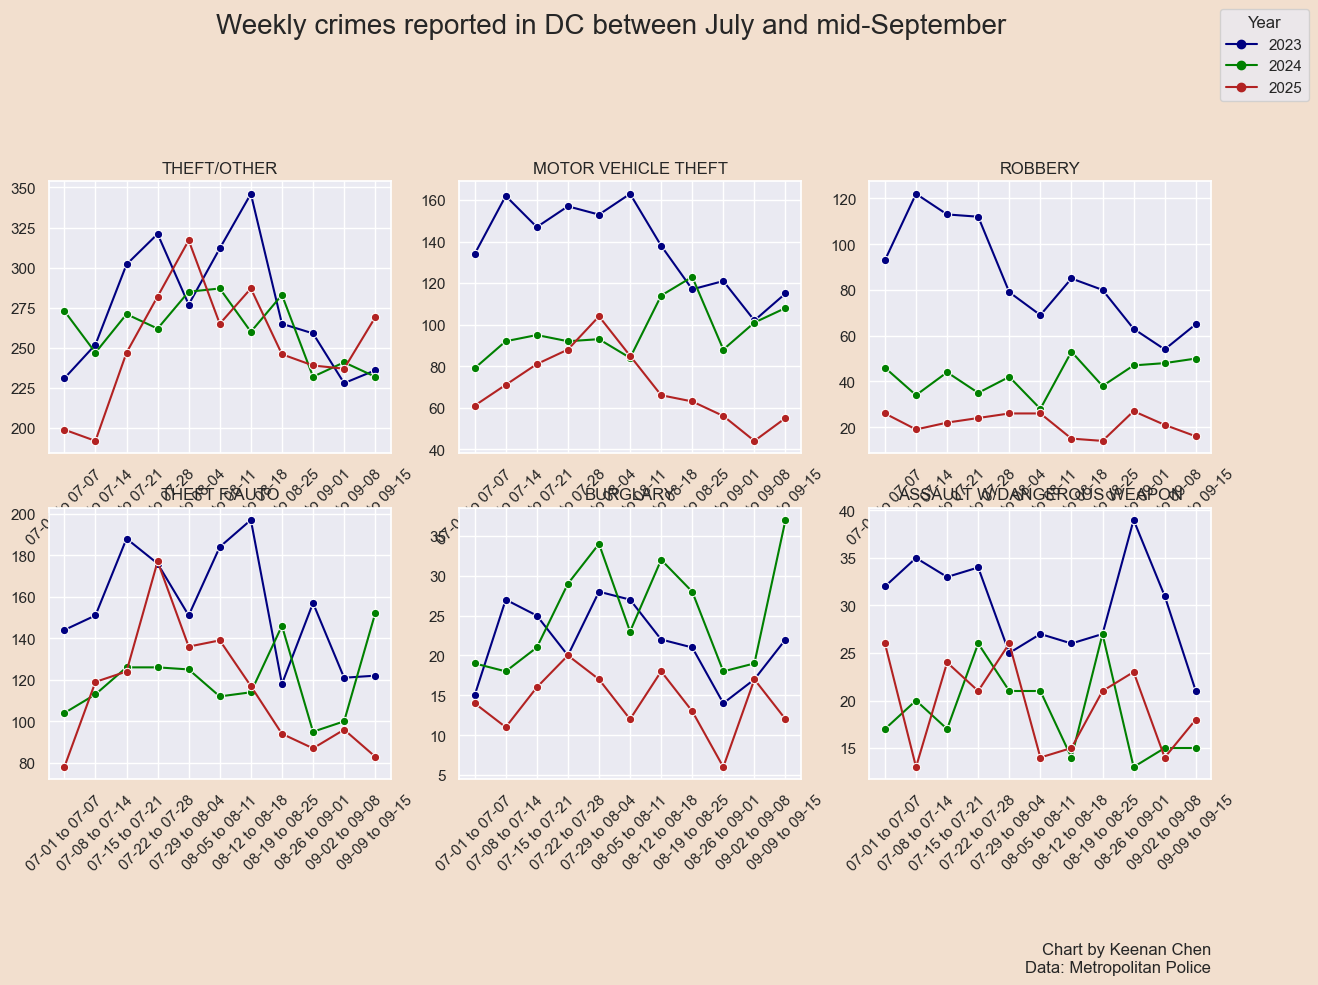

In [ ]:
sns.set_palette('dark')
sns.set_theme(style="darkgrid")
sns.set(rc={ 'figure.facecolor':'#F2DFCE'})


fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, each_offense in enumerate(s1['offense'].unique()):
    subset_2023 = s1[(s1.offense == each_offense) & (s1.reported_year == 2023)]
    subset_2024 = s1[(s1.offense == each_offense) & (s1.reported_year == 2024)]
    subset_2025 = s1[(s1.offense == each_offense) & (s1.reported_year == 2025)]
    
    # Aggregate by week_label
    subset_2023 = subset_2023.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')
    subset_2024 = subset_2024.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')
    subset_2025 = subset_2025.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')
    
    subset_combined = pd.concat([
        subset_2023.assign(year=2023),
        subset_2024.assign(year=2024),
        subset_2025.assign(year=2025)
    ])
    
    sns.lineplot(
        data=subset_combined,
        x='week_label',
        y='count',
        hue='year',
        marker='o',
        palette=['navy', 'green', 'firebrick'],
        ax=axes[i],
        legend=False
  
      
    )
    
    axes[i].set_title(each_offense, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticks(range(len(x_labels)))
    axes[i].set_xticklabels(x_labels, rotation=45)
    axes[i].grid(True)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

import matplotlib.lines as mlines

green_line = mlines.Line2D([], [], color='navy', marker='o', label='2023')
blue_line = mlines.Line2D([], [], color='green', marker='o', label='2024')
red_line = mlines.Line2D([], [], color='firebrick', marker='o', label='2025')

fig.legend(
    handles=[green_line, blue_line, red_line],
    title="Year",
    loc='upper right',
    bbox_to_anchor=(0.97, 1.03),
    ncol=1
)

last_ax = axes[i] 
last_ax.text(
    1.0, -0.6, 
    "Chart by Keenan Chen\nData: Metropolitan Police",
    ha='right', va='top',
    fontsize=12,
    transform=last_ax.transAxes
)

plt.tight_layout(rect=[0, 1, 1, 1])

title_text = 'Weekly crimes reported in DC between July and mid-September'
plt.suptitle(title_text, fontsize=20, y=1.02)

safe_filename = f'{viz_dir}/weekly_crimes_dc.jpeg'  # avoid long spaces
plt.savefig(safe_filename, bbox_inches='tight', dpi=500)

plt.show()

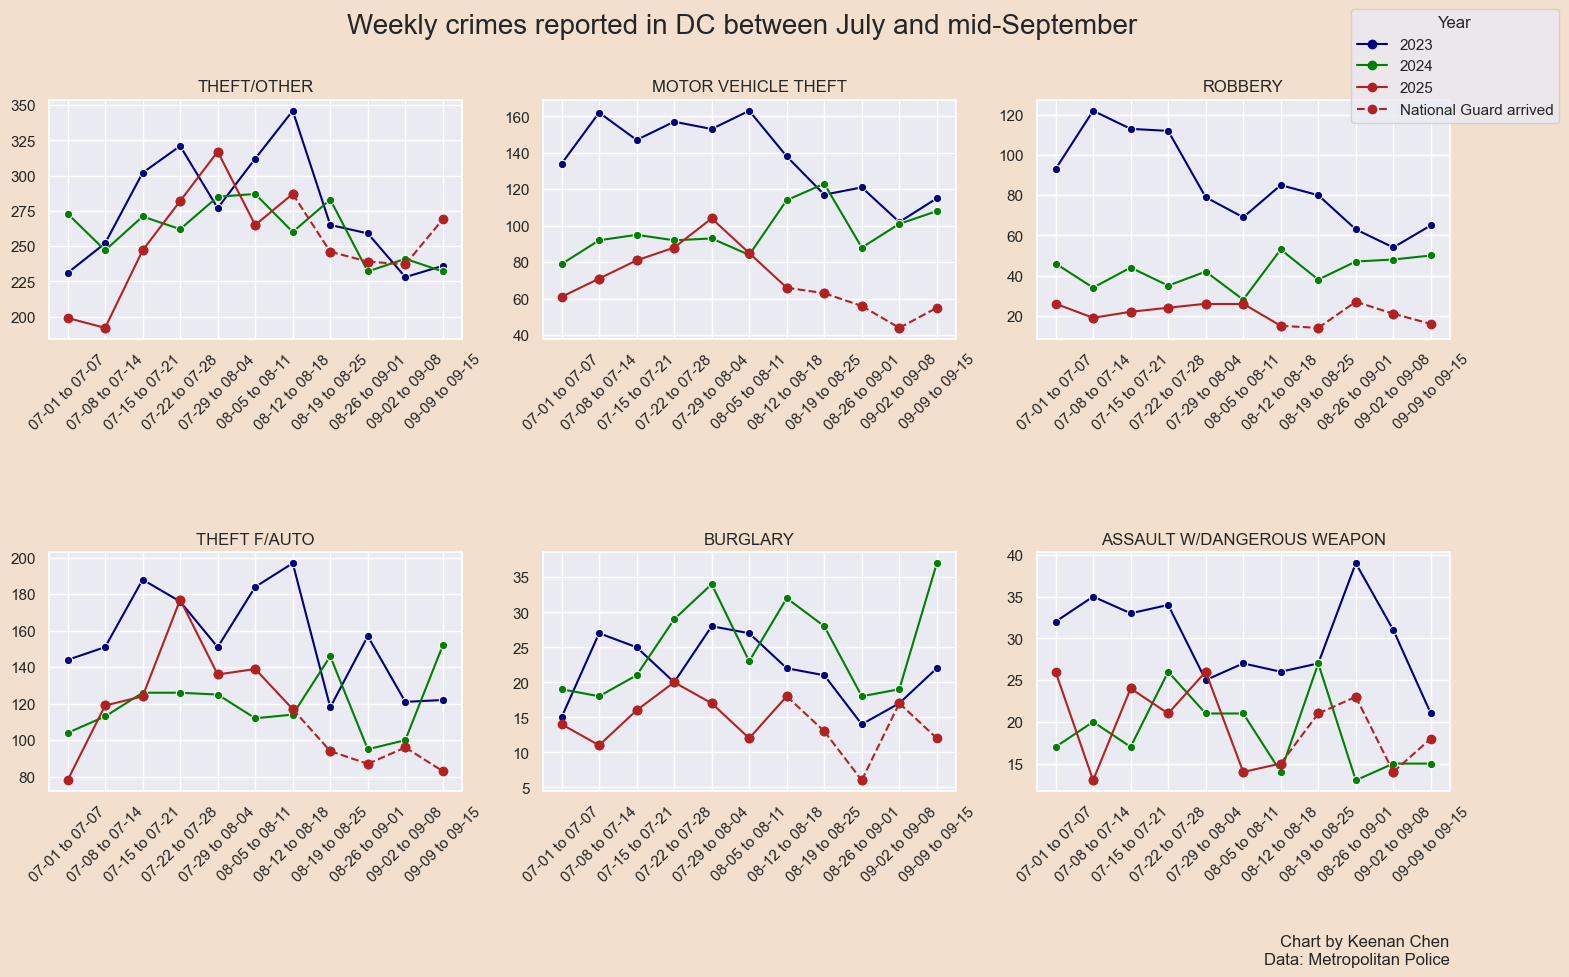

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, each_offense in enumerate(s1['offense'].unique()):
    subset_2023 = s1[(s1.offense == each_offense) & (s1.reported_year == 2023)]
    subset_2024 = s1[(s1.offense == each_offense) & (s1.reported_year == 2024)]
    subset_2025 = s1[(s1.offense == each_offense) & (s1.reported_year == 2025)]
    
    # Aggregate by week_label
    subset_2023 = subset_2023.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')
    subset_2024 = subset_2024.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')
    subset_2025 = subset_2025.groupby('week_label').size().reindex(x_labels, fill_value=0).reset_index(name='count')

    # Plot 2023 and 2024 normally with Seaborn
    sns.lineplot(
        data=subset_2023,
        x='week_label', y='count',
        marker='o',
        color='navy',
        ax=axes[i]
    )
    sns.lineplot(
        data=subset_2024,
        x='week_label', y='count',
        marker='o',
        color='green',
        ax=axes[i]
    )

    # Custom plot for 2025 with conditional linestyle
    weeks_numeric = range(len(subset_2025))
    cutoff_idx = subset_2025[subset_2025['week_label'] >= '08-12'].index[0]  # first week >= 08-12
    for j in range(len(subset_2025)-1):
        linestyle = '--' if j >= cutoff_idx else '-'  # dashed from cutoff onwards
        axes[i].plot(
            [weeks_numeric[j], weeks_numeric[j+1]],
            [subset_2025['count'].iloc[j], subset_2025['count'].iloc[j+1]],
            color='firebrick',
            marker='o',
            linestyle=linestyle
        )

    axes[i].set_title(each_offense, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticks(range(len(x_labels)))
    axes[i].set_xticklabels(x_labels, rotation=45)
    axes[i].grid(True)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

import matplotlib.lines as mlines

navy_line = mlines.Line2D([], [], color='navy', marker='o', label='2023')
green_line = mlines.Line2D([], [], color='green', marker='o', label='2024')
red_line = mlines.Line2D([], [], color='firebrick', marker='o', label='2025')
red_dashed = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='--', label="National Guard arrived")

fig.legend(
    handles=[navy_line, green_line, red_line, red_dashed],
    title="Year",
    loc='upper right',
    bbox_to_anchor=(1.05, 1.05),
    ncol=1
)

last_ax = axes[i] 
last_ax.text(
    1, -0.6, 
    "Chart by Keenan Chen\nData: Metropolitan Police",
    ha='right', va='top',
    fontsize=12,
    transform=last_ax.transAxes
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.suptitle('Weekly crimes reported in DC between July and mid-September', fontsize=20, y=1.04)
plt.savefig(safe_filename, bbox_inches='tight', dpi=500)
plt.show()
